In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI, FMRI_SURFACE_LEVEL_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, IDS_IMAGES_TEST, IDS_IMAGES_IMAGERY, IMAGERY_SCENES
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, Normalize, IMAGE, CAPTION, get_distance_matrix, \
ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, calc_all_pairwise_accuracy_scores, get_nn_latent_data

from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, PALETTE_BLACK_ONLY, METRICS_IMAGERY

In [2]:
# MODELS = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
#                "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
#                "visualbert", "lxmert", "bridgetower-large", "vilt", "clip", "imagebind", "flava", "blip2"]
MODEL = "blip2"

all_data = load_results_data([MODEL], metrics=METRICS_IMAGERY)

all_data = all_data[pd.isna(all_data["mask"])]
all_data = all_data[all_data.surface == False]

all_data
# for model in MODEL_ORDER:
#     print(model, end=" ")
# all_data = all_data[all_data.subject.isin(['sub-01', 'sub-02', 'sub-03', 'sub-04'])]
# all_data_glow_comparisons

100%|██████████| 1197/1197 [00:02<00:00, 559.20it/s]


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
0,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,predictions,"[[0.0056858445, -0.0073180436, 0.0019684248, -...",False,NaN,blip2_avg
1,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,latents,"[[-0.032183096, 0.9773568, -1.0357457, -0.8727...",False,NaN,blip2_avg
2,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",False,NaN,blip2_avg
3,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,stimulus_types,"[caption, caption, caption, caption, caption, ...",False,NaN,blip2_avg
4,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.889441,False,NaN,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,100000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,predictions,"[[0.0064259926, 0.0047780667, 0.019857641, -0....",False,NaN,blip2_matched
889,100000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,latents,"[[-1.6874626, 1.2519206, -1.9531332, 0.1161772...",False,NaN,blip2_matched
890,100000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",False,NaN,blip2_matched
891,100000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,stimulus_types,"[caption, caption, caption, caption, caption, ...",False,NaN,blip2_matched


In [3]:
def get_data_default_feats(data):
    data_default_feats = data.copy()
    for model in data.model.unique():
        default_feats = get_default_features(model)
        default_vision_feats = get_default_vision_features(model)
        default_lang_feats = get_default_lang_features(model)
        data_default_feats = data_default_feats[((data_default_feats.model == model) & (data_default_feats.features == default_feats) & (data_default_feats.vision_features == default_vision_feats) & (data_default_feats.lang_features == default_lang_feats)) | (data_default_feats.model != model)]
        
    return data_default_feats
    
data_default_feats = get_data_default_feats(all_data)

Selected default features for blip2: avg
Selected default vision features for blip2: vision_features_mean
Selected default lang features for blip2: lang_features_mean


### Model performance ranking

In [4]:
dp = data_default_feats.copy()
dp = dp[dp.training_mode == 'modality-agnostic']

dp = dp[dp.metric == ACC_IMAGERY_WHOLE_TEST]
for model in dp.model.unique():
    if len(dp[dp.model == model]) != len(SUBJECTS):
        print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
scores = dp.groupby("model").value.mean().sort_values()

print(scores)

model
blip2    0.796948
Name: value, dtype: object


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


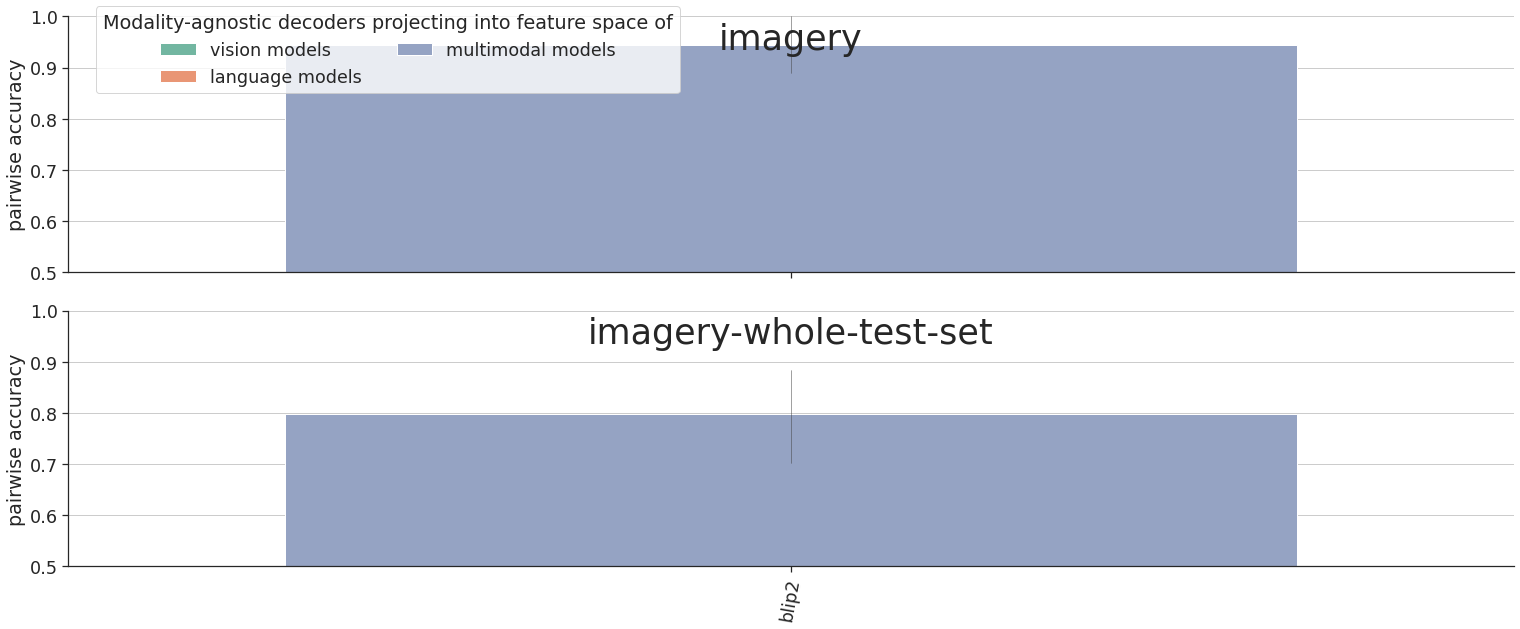

In [5]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = ["blip2_avg"]

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [61]:
train_latents = dict()
train_stim_ids = dict()
for subject in SUBJECTS:
    features = data_default_feats.features.values[0]
    print(features)
    vision_features = data_default_feats.vision_features.values[0]
    print(vision_features)
    lang_features = data_default_feats.lang_features.values[0]
    print(lang_features)
    all_stim_ids = pickle.load(open(STIMULI_IDS_PATH, "rb"))
    train_stim_ids[subject] = np.array(list(set(all_stim_ids) - set(IDS_IMAGES_IMAGERY) - set(IDS_IMAGES_TEST)))
    train_stim_types = ["image"] * len(train_stim_ids[subject])
    train_latents[subject], _ = get_nn_latent_data(
                                        MODEL, features,
                                        vision_features,
                                        lang_features,
                                        train_stim_ids[subject],
                                        train_stim_types,
                                        subject,
                                        "train",
                                        recompute_std_mean=False
                                    )

avg
vision_features_mean
lang_features_mean
[131074 262146 524291 ... 131063 524280 393212]
{'sub-01': array([131074, 262146, 524291, ..., 131063, 524280, 393212])}
avg
vision_features_mean
lang_features_mean
[131074 262146 524291 ... 131063 524280 393212]
{'sub-01': array([131074, 262146, 524291, ..., 131063, 524280, 393212]), 'sub-02': array([131074, 262146, 524291, ..., 131063, 524280, 393212])}
avg
vision_features_mean
lang_features_mean
[131074 262146 524291 ... 131063 524280 393212]
{'sub-01': array([131074, 262146, 524291, ..., 131063, 524280, 393212]), 'sub-02': array([131074, 262146, 524291, ..., 131063, 524280, 393212]), 'sub-03': array([131074, 262146, 524291, ..., 131063, 524280, 393212])}
avg
vision_features_mean
lang_features_mean
[131074 262146 524291 ... 131063 524280 393212]
{'sub-01': array([131074, 262146, 524291, ..., 131063, 524280, 393212]), 'sub-02': array([131074, 262146, 524291, ..., 131063, 524280, 393212]), 'sub-03': array([131074, 262146, 524291, ..., 131063

In [30]:
all_scores = []

df = data_default_feats.copy()
df_model = df[df.model == MODEL]
all_subj_mats = []
for subject in SUBJECTS:
    df_subj = df_model[(df_model.training_mode == 'modality-agnostic') & (df_model.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

    latents_image = latents[stimulus_types == IMAGE]
    latents_caption = latents[stimulus_types == CAPTION]

    target_latents = np.concatenate((imagery_latents, latents))
    # target_latents = np.concatenate((imagery_latents, train_latents[subject]))

    res = pairwise_accuracy(target_latents, imagery_predictions)
    
    print(res)
        # all_scores.append(res[ACC_IMAGES])
        # break
# print(np.mean(all_scores))



0.8661971830985915
0.6830985915492958
0.6220657276995305
0.8732394366197183
0.795774647887324
0.9413145539906104


In [71]:
from utils import COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH
from feature_extraction.feat_extraction_utils import CoCoDataset
coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'image')

In [77]:
all_scores = []

df = data_default_feats.copy()
df_model = df[df.model == MODEL]
all_subj_mats = []
for subject in SUBJECTS:
    df_subj = df_model[(df_model.training_mode == 'modality-agnostic') & (df_model.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

    latents_image = latents[stimulus_types == IMAGE]
    latents_caption = latents[stimulus_types == CAPTION]

    # target_latents = np.concatenate((imagery_latents, latents))
    target_latents = np.concatenate((imagery_latents, train_latents[subject]))
    imagery_stimulus_ids = np.array([i[1] for i in IMAGERY_SCENES[subject]])
    print(imagery_stimulus_ids)
    # train_ids = np.array(t)
    # print(train_ids.shape)
    target_latents_ids = np.concatenate((imagery_stimulus_ids, train_stim_ids[subject]))
   
    preds_normalize = Normalize(imagery_predictions.mean(axis=0), imagery_predictions.std(axis=0))
    imagery_predictions = preds_normalize(imagery_predictions)

    dist_mat = get_distance_matrix(imagery_predictions, target_latents)
    
    print(dist_mat.shape)
    print(dist_mat[2])
    for img_id in target_latents_ids[np.argsort(dist_mat[2])[:10]]:
        print(img_id)
        # display(coco_ds[img_id])
    break
# print(np.mean(all_scores))

# TODO:         499141499141499141499141499141499141499141499141499141499141499141



[406591 324670 563723]
(3, 41187)
[0.94539133 1.08192709 0.74930166 ... 1.21696382 0.92525259 1.1942518 ]
174042
272119
499141
341189
388599
167408
139109
493862
113617
288180


In [72]:
coco_ds[568962]

IndexError: list index out of range

## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]

    for mode in ["modality-agnostic", "captions", "images"]:
        data_mode = data[data.training_mode == mode]
        for m_feat in model_feat_order:
            length = len(data_mode[(data_mode.model_feat == m_feat) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            if hue_variable != "features":
                expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {m_feat} {mode}"
                if verify_num_datapoints:
                    raise RuntimeError(message)
                else:
                    print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            # _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
            #                               hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            # _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
            #                               hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | {metrics[0]}", fontsize=25)
            # catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = ["blip2_avg"]

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_IMAGERY], hue_order=FEAT_ORDER, ylim=(0.3, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# 